In [1]:
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
from pathlib import Path
import json
import math
from matplotlib import ticker

In [2]:
m.rcParams.update({"font.size": 24, "legend.fontsize": 20, 'pdf.fonttype': 42, 'ps.fonttype': 42})
export_format = "pdf"

In [3]:
workload_display_name = {
    "addpd": "128b SSE Add (1 Thread)",
    "busywait": "Busy Waiting",
    "compute": "Dot Product (1 Thread)",
    "idle": "Sleep",
    "matmul": "DGEMM (1 Thread)",
    "memorycopy": "Memory Copy (32 Threads)",
    "memoryread": "Memory Read (32 Threads)",
    "memorywrite": "Memory Write (32 Threads)",
    "memorycopy_4": "Memory Copy (4 Threads)",
    "memoryread_4": "Memory Read (4 Threads)",
    "memorywrite_4": "Memory Write (4 Threads)",
    "mulpd": "128b SSE Mult. (1 Thread)",
    "stream_add": "STREAM Add (32 Threads)",
    "stream_add_4": "STREAM Add (4 Threads)",
    "stream_combined": "STREAM (32 Threads)",
    "stream_combined_4": "STREAM (4 Threads)",
    "stream_copy_1": "STREAM Copy (1 Thread)",
    "stream_copy_2": "STREAM Copy (2 Threads)",
    "stream_copy_4": "STREAM Copy (4 Threads)",
    "stream_copy_16": "STREAM Copy (16 Threads)",
    "stream_copy_24": "STREAM Copy (24 Threads)",
    "stream_copy_32": "STREAM Copy (32 Threads)",
    "stream_copy_8": "STREAM Copy (8 Threads)",
    "stream_scale": "STREAM Scale (32 Threads)",
    "stream_scale_4": "STREAM Scale (4 Threads)",
    "stream_triad": "STREAM Triad (32 Threads)",
    "stream_triad_4": "STREAM Triad (4 Threads)"

}

In [4]:
energy_errors = {} 

In [5]:
def savefig(fig, name):
    fig.savefig(name + "." + export_format, format=export_format, bbox_inches="tight")


In [6]:
def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", format="pdf", bbox_inches=bbox)

In [7]:
def read_reference(path, config):
    df = pd.read_csv(path, names=[f"v{i}" for i in [0, 1, 2, 3, 4, 5, 6, 7]], header=None)
    channel_config = config["channels"]
    dimm_channels = {}
    
    for channel in channel_config:
        key = str(channel["riser"]) + "-" + channel['name']
        multiplier = 1.0 if "riser_multipliers" not in config else config["riser_multipliers"][channel["riser"]]
        df_voltage = df[f"v{channel['voltage_channel']}"] / channel["voltage_gain"]
        df_current = df[f"v{channel['voltage_drop_channel']}"] / channel["gain"] / channel["csr_resistance"]
        df[key] = df_voltage * df_current * multiplier
        channels_per_dimm = []
        if channel["riser"] in dimm_channels:
            channels_per_dimm = dimm_channels[channel["riser"]]
        channels_per_dimm.append(key)
        dimm_channels[channel["riser"]] = channels_per_dimm
        
    return df, dimm_channels

In [8]:
def read_rapl(path, config):
    rapl_energy_sum = 0.0
    sockets = [0] if "sockets" not in config else config["sockets"]
    rapl_entries = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#") or line == "":
                continue
            split = line.split(",")
            if len(split) < 5:
                continue
            timestamp = float(split[0])
            delay = float(split[1])
            event_name = split[3]
            socket = split[2]
            energy = split[4]
            power = split[5]
            if "ram" not in event_name:
                continue

            if int(socket.replace("N", "")) not in sockets:
                continue

            column = "RAPL_" + socket + "_" + event_name
            if column in rapl_entries:
                d = rapl_entries[column]
            else:
                d = []
            rapl_energy_sum += float(energy)
            d.append({"time": timestamp * 1000, "power": float(power), "energy": float(energy), "length": delay})
            rapl_entries[column] = d
    return rapl_entries, rapl_energy_sum

In [9]:
def create_phase_plot(mid: str, source_dir, name: str, config, base_folder):
    avg = 25
    fig, ax = plt.subplots(figsize=(9, 3))
    
    raw_name = name
    if name in workload_display_name:
        name = workload_display_name[name]
    
    ref_df, dimm_channels = read_reference(Path(source_dir, mid + ".csv"), config)
    rapl_entries, rapl_energy_sum = read_rapl(Path(source_dir, mid + '_perf.txt'), config)
    
    max_time = 0.0
    rapl_colors = ["tab:orange", "tab:blue"]
    dimm_colors = ["tab:orange", "tab:blue"]
    additional_colors = ["magenta", "cyan", "brown"]

    rapl_energy_total = 0.0
    # visualize rapl entries
    for i, (event_name, items) in enumerate(rapl_entries.items()):
        df_rapl = pd.DataFrame.from_records(items)
        ax.plot(df_rapl["time"], df_rapl["power"].rolling(5, min_periods=1).mean(), color=rapl_colors[i], linewidth=1, label=f"RAPL: Socket {0 if 'N0' in event_name else 1}")
        max_time = np.max([np.max(df_rapl["time"]), max_time])
        rapl_energy_total += np.sum(df_rapl["energy"])

    # visualize reference entries
    all_channels = []
    total_energy = 0.0
    
    dur_ms = int(np.floor(max_time))
    for dimm_index in dimm_channels:
        ax.plot(ref_df.index, (ref_df[dimm_channels[dimm_index]].sum(axis=1)).rolling(avg, min_periods=1).mean(),
                color=dimm_colors[dimm_index],
                linewidth=1,
                linestyle="dashed",
                label="Reference: " + config['riser_names'][dimm_index])
        x_array = ref_df.index[:dur_ms]
        y_array = ref_df[dimm_channels[dimm_index]].sum(axis=1)[x_array]
        energy = np.trapz(y_array, dx=0.001)  # 1 ms granularity
        total_energy += energy
        avg_power = energy / (dur_ms / 1000)
        for d in dimm_channels[dimm_index]:
            all_channels.append(d)
    
    rapl_relative_error = rapl_energy_total / total_energy
    
    if name not in energy_errors:
        energy_errors[name] = {}
    
    system_tag = "icelake" if "icelake" in source_dir else "broadwell"
    if system_tag not in energy_errors[name]:
        energy_errors[name][system_tag] = {}
        
    energy_errors[name][system_tag][source_dir] = rapl_relative_error
        
    print(mid, source_dir, total_energy, rapl_energy_total, f"{dur_ms/1000:.4f}s", f"{rapl_relative_error * 100:.2f}%")
    
    # visualize sum of reference measurements
    if "plot_sum" in config and config["plot_sum"]:
        ax.plot(ref_df.index, (ref_df[all_channels].sum(axis=1)).rolling(avg, min_periods=1).mean(),
                color="tab:green",
                linestyle="dotted",
                linewidth=1,
                label="Total Reference Measurements")
        
    # visualize baselines (optional)
    if "baselines" in config:
        for ind, baseline_conf in enumerate(config["baselines"]):
            ax.axhline(y=baseline_conf["power"], color=additional_colors[ind], linestyle='-.', linewidth=1, label=baseline_conf["label"])
    
    

    #ax.axvline(x=max_time, color="black")
    ax.set_xlim(right=min(max_time + 500, ax.get_xlim()[1]))
    ax.set_ylim(bottom=max(0, ax.get_ylim()[0]))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

        
    tr = 1000
    if ax.get_xlim()[1] >= 20000:
        tr = 5000
    elif ax.get_xlim()[1] >= 6000:
        tr = 2000
    ax.set_xticks(np.arange(0, ax.get_xlim()[1], tr))
    ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1000), minor=True)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Power [W]")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, a: f"{int(x/1000)}"))
    ax.set_xlim(left=0, right=max_time)
    ax.grid(which="minor", alpha=.3)
    ax.grid(which="major", alpha=.8)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, prop={'size': 12})
    
    savefig(fig, base_folder + "/" + raw_name)

In [10]:
def visualize_phase_plots(root_folder, base_subfolders):
    for base_subfolder in base_subfolders:
        base_folder = root_folder + base_subfolder
        
        if Path(base_folder, "config.json").exists():
            with open(Path(base_folder, "config.json"), "r") as f:
                config = json.load(f)
        else:
            continue

        for folder in Path(base_folder).iterdir():
            name = str(folder).split("\\")[-1]
            subfolder = Path(folder)
            if subfolder.is_file():
                continue
            if str(subfolder).split("\\")[-1].startswith("-"):
                continue
            for file in subfolder.iterdir():
                if "_perf.txt" in str(file):
                    mid = str(file).split("\\")[-1].split("_")[0]
                    create_phase_plot(mid, str(subfolder), name=name, config=config, base_folder=base_folder)


In [11]:
def visualize_scatter_plot(root_folder, base_subfolders, extra_legend=False, legend_cols=3):
    
    colors = ["#FF0000", "#00FF00", "#0000FF", "#000000", "#FF00FF", "#00FFFF", "#FFA500", "#800080", "#008000", "#800000", "#808000", "#008080", "#808080", "#C0C0C0", "#FFD700", "#B22222", "#228B22", "#32CD32", "#87CEEB", "#40E0D0", "#D2691E", "#DC143C", "#FF1493", "#A0522D", "#800080"]
    markers = list(filter(lambda x: x != "none" and x != "None" and x != "" and x != " ",  MarkerStyle.markers))
         
    for base_subfolder in base_subfolders:
        base_folder = root_folder + base_subfolder
        
        combined_df = pd.DataFrame()
        corr_fig, corr_ax = plt.subplots(figsize=(8,8))

        if Path(base_folder, "config.json").exists():
            with open(Path(base_folder, "config.json"), "r") as f:
                config = json.load(f)
        else:
            continue
            
          
        sockets = [0] if "sockets" not in config else config["sockets"]
        index = 0
        for folder in sorted(Path(base_folder).iterdir(), key=str):
            name = str(folder).split("\\")[-1]
            subfolder = Path(folder)
            if subfolder.is_file():
                continue
            if str(subfolder).split("\\")[-1].startswith("-"):
                continue
            for file in subfolder.iterdir():
                if "_perf.txt" in str(file):
                    print(index, file)
                    mid = str(file).split("\\")[-1].split("_")[0]
                    
                    if name in workload_display_name:
                        name = workload_display_name[name]
                    source_dir = str(subfolder)
                    ref_df, dimm_channels = read_reference(Path(source_dir, mid + ".csv"), config)
                    rapl_entries, rapl_energy_sum = read_rapl(Path(source_dir, mid + '_perf.txt'), config)

                    all_channels = []
                    total_energy = 0.0
                    for dimm_index in dimm_channels:
                        for d in dimm_channels[dimm_index]:
                            all_channels.append(d)

                    align = "200ms"
                    for dimm_index in dimm_channels:
                        ref_df["power_daq_" + config['riser_names'][dimm_index]] = ref_df[dimm_channels[dimm_index]].sum(axis=1)
                    ref_df["power_daq"] = ref_df[all_channels].sum(axis=1)
                    daq_df = ref_df.reset_index(names=["time"])
                    daq_df["time"] = pd.to_timedelta(daq_df["time"], unit="ms")
                    daq_df = daq_df.set_index("time").resample(align, offset=0).mean()
                    rapl_df = pd.DataFrame.from_records(rapl_entries[f"RAPL_N{sockets[0]}_ram"])[["time", "power"]].rename(
                        columns={"power": "power_rapl"})
                    rapl_df["time"] = pd.to_timedelta(rapl_df["time"], unit="ms")
                    rapl_df["time"] = rapl_df["time"].dt.floor(align)
                    rapl_df = rapl_df.set_index("time").resample(align, offset=0).mean()

                    merged = pd.merge(daq_df, rapl_df, on="time")
                    merged.sample(n=min(100, len(merged)), random_state=123).plot.scatter(x="power_daq", y="power_rapl", ax=corr_ax, label=name, s=100, c=colors[index % len(colors)],
                                        marker=MarkerStyle(markers[index % len(markers)], fillstyle="none"),  linewidths=1.5)
                    combined_df = pd.concat([combined_df, merged])
                    break
            index += 1
        corr_ax.set_xlabel("Riser Power Measurements [W]", labelpad=15)
        corr_ax.set_ylabel("RAPL Memory Power [W]", labelpad=15)
        max_lim = max(corr_ax.get_xlim()[1], corr_ax.get_ylim()[1])
        min_lim = min(corr_ax.get_xlim()[0], corr_ax.get_ylim()[0])
        corr_ax.set_xlim(left=min_lim, right=max_lim)
        corr_ax.set_ylim(bottom=min_lim, top=max_lim)
        if(min_lim < 0.5):
            min_lim = 0
        corr_ax.set_xticks(np.arange(math.ceil(corr_ax.get_xlim()[0]), math.ceil(corr_ax.get_xlim()[1]), 1))
        corr_ax.set_yticks(np.arange(math.ceil(corr_ax.get_ylim()[0]), math.ceil(corr_ax.get_ylim()[1]), 1))
        corr_ax.set_xticks(np.arange(max(0.5, np.floor(min_lim) + 0.5), min(max_lim, np.floor(max_lim) + 0.5), 1), minor=True)
        corr_ax.set_yticks(np.arange(max(0.5, np.floor(min_lim) + 0.5), min(max_lim, np.floor(max_lim) + 0.5), 1), minor=True)
        
        x_keys = np.arange(min_lim, max_lim, 0.5)
        corr_ax.plot(x_keys, x_keys, linestyle="dotted", label="Ideal Fit", linewidth=1, color="gray")  # black dashed line

        x = combined_df["power_daq"]
        y = combined_df["power_rapl"]
        slope, intercept = np.polyfit(x, y, 1)
        corr_ax.plot(x_keys, x_keys * slope + intercept, linestyle="dashed", label="Linear Fit", linewidth=1, color="red")
            
        handles, labels = corr_ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        
        def extract_key(key):
            m = key[0].lower()
            if "fit" in m:
                return "zzzz" 
            elif "(" in m:
                tr = m.split("(")[1].split(" ")[0]
                return m.split("(")[0] + tr.zfill(3)
            else:
                return m
                
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: extract_key(t)))
        
        if not extra_legend:
            corr_ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=legend_cols, prop={'size': 13})
        else:
            legend = corr_ax.legend(handles, labels, loc=(1.5,1.5), ncol=5, prop={'size': 13})
            export_legend(legend, filename=base_folder + "/scatter_legend.pdf")
            corr_ax.legend().remove()

        corr_ax.grid(which="minor", alpha=.3)
        corr_ax.grid(which="major", alpha=.8)

        savefig(corr_fig, base_folder + "/scatter")

In [12]:
from textwrap import wrap
def visualize_combined_scatter_plot(root_folder, base_subfolders):
    corr_fig, corr_ax = plt.subplots(figsize=(8,8))
    linear_fits = []

    for memory_index, base_subfolder in enumerate(base_subfolders):
        base_folder = root_folder + base_subfolder
        
        combined_df = pd.DataFrame()

        if Path(base_folder, "config.json").exists():
            with open(Path(base_folder, "config.json"), "r") as f:
                config = json.load(f)
        else:
            continue
        label = config["memory_population"]
        sockets = [0] if "sockets" not in config else config["sockets"]
        
        colors = ["tab:orange", "tab:blue", "tab:cyan", "tab:red", "tab:green"]
        
        for index, folder in enumerate(Path(base_folder).iterdir()):
            name = str(folder).split("\\")[-1]
            subfolder = Path(folder)
            if subfolder.is_file():
                continue
            if str(subfolder).split("\\")[-1].startswith("-"):
                continue
            for file in subfolder.iterdir():
                if "_perf.txt" in str(file):
                    mid = str(file).split("\\")[-1].split("_")[0]
                    
                    if name in workload_display_name:
                        name = workload_display_name[name]
                    source_dir = str(subfolder)
                    ref_df, dimm_channels = read_reference(Path(source_dir, mid + ".csv"), config)
                    rapl_entries, rapl_energy_sum = read_rapl(Path(source_dir, mid + '_perf.txt'), config)

                    all_channels = []
                    total_energy = 0.0
                    for dimm_index in dimm_channels:
                        for d in dimm_channels[dimm_index]:
                            all_channels.append(d)

                    align = "200ms"
                    for dimm_index in dimm_channels:
                        ref_df["power_daq_" + config['riser_names'][dimm_index]] = ref_df[dimm_channels[dimm_index]].sum(axis=1)
                    ref_df["power_daq"] = ref_df[all_channels].sum(axis=1)
                    daq_df = ref_df.reset_index(names=["time"])
                    daq_df["time"] = pd.to_timedelta(daq_df["time"], unit="ms")
                    daq_df = daq_df.set_index("time").resample(align, offset=0).mean()
                    rapl_df = pd.DataFrame.from_records(rapl_entries[f"RAPL_N{sockets[0]}_ram"])[["time", "power"]].rename(
                        columns={"power": "power_rapl"})
                    rapl_df["time"] = pd.to_timedelta(rapl_df["time"], unit="ms")
                    rapl_df["time"] = rapl_df["time"].dt.floor(align)
                    rapl_df = rapl_df.set_index("time").resample(align, offset=0).mean()

                    merged = pd.merge(daq_df, rapl_df, on="time")
                    markers = ["1", "+", ".", "p", "*"]
                    merged.sample(n=min(25, len(merged)), random_state=123).plot.scatter(x="power_daq", y="power_rapl", ax=corr_ax, label=label, s=40, c=colors[memory_index % len(colors)],
                                        marker=MarkerStyle(markers[memory_index % len(markers)], fillstyle="none"),  linewidths=1)
                    combined_df = pd.concat([combined_df, merged])
        
        x = combined_df["power_daq"]
        y = combined_df["power_rapl"]
        slope, intercept = np.polyfit(x, y, 1)
        linear_fits.append((slope, intercept))
        
    
    
    corr_ax.set_xlabel("Riser Power Measurements [W]", labelpad=15)
    corr_ax.set_ylabel("RAPL Memory Power [W]", labelpad=15)
    max_lim = max(corr_ax.get_xlim()[1], corr_ax.get_ylim()[1])
    min_lim = min(corr_ax.get_xlim()[0], corr_ax.get_ylim()[0])
    if(min_lim < 0.5):
        min_lim = 0
    corr_ax.set_xlim(left=min_lim, right=max_lim)
    corr_ax.set_ylim(bottom=min_lim, top=max_lim)
    corr_ax.set_xticks(np.arange(math.ceil(corr_ax.get_xlim()[0]), math.ceil(corr_ax.get_xlim()[1]), 1))
    corr_ax.set_yticks(np.arange(math.ceil(corr_ax.get_ylim()[0]), math.ceil(corr_ax.get_ylim()[1]), 1))
    corr_ax.set_xticks(np.arange(max(0.5, np.floor(min_lim) + 0.5), min(max_lim, np.floor(max_lim) + 0.5), 1), minor=True)
    corr_ax.set_yticks(np.arange(max(0.5, np.floor(min_lim) + 0.5), min(max_lim, np.floor(max_lim) + 0.5), 1), minor=True)

    x_keys = np.arange(corr_ax.get_xlim()[0], corr_ax.get_xlim()[1], 0.5)
    corr_ax.plot(x_keys, x_keys, linestyle="dashdot", label="Ideal Fit", linewidth=1, color="black")  # black dashed line
    for index, (slope, intercept) in enumerate(linear_fits):
        corr_ax.plot(x_keys, x_keys * slope + intercept, linestyle="dashed", linewidth=1, color=colors[index])
    corr_ax.plot([0], [0], linestyle="dashed", linewidth=1, color="gray", label="Linear Fit")
    handles0, labels0 = corr_ax.get_legend_handles_labels()
    labels = []
    handles = []

    for label, handle in zip(labels0, handles0):
        label = '\n'.join(wrap(label, 20))
        if label not in labels:
            labels.append(label)
            handles.append(handle)
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: "_" + t[0].lower() if "Fit" in t[0] else "__" + t[0].lower() if "PMM" in t[0] else t[0].lower()))

    #box = corr_ax.get_position()
    #corr_ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

    # Put a legend to the right of the current axis
    corr_ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, prop={'size': 13}, scatterpoints=3)

    corr_ax.grid(which="minor", alpha=.3)
    corr_ax.grid(which="major", alpha=.8)

    savefig(corr_fig, root_folder + "/combined_scatter")

6def37cd broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\addpd 16.561900094622107 17.8682 107.89%
7cd7e030 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\busywait 16.530595900829425 17.842 107.93%
8dc6d845 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\compute 31.79431147375893 33.081199999999995 104.05%
759d8d02 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\idle 9.169530786880086 12.404 135.27%
d4e6e0b3 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\matmul 16.608284055696952 17.9373 108.00%
9c27e139 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memorycopy 42.912020279361265 39.894200000000005 92.97%
0f4e5b82 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memoryread 37.33734943722617 37.2893 99.87%
0d46d2a3 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memorywrite 42.962440014689946 40.008100000000006 93.12%
68f56b35 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\mulpd 16.549455755569895 17.903 108.18%
bf1bfecb broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\stream_add 192.20896879300258 173.80

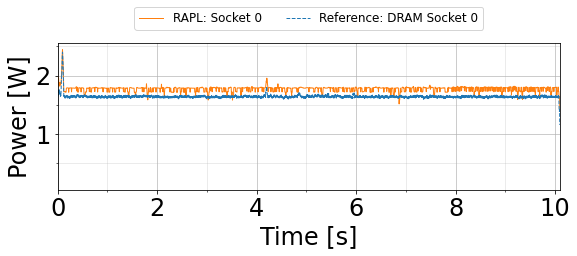

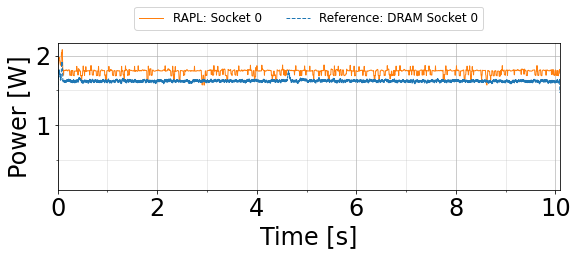

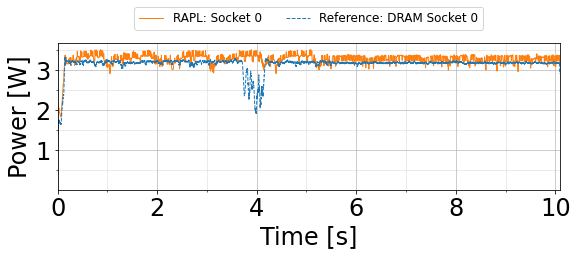

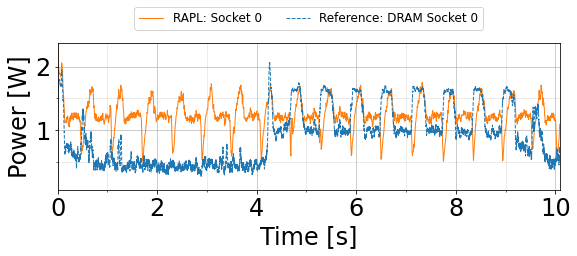

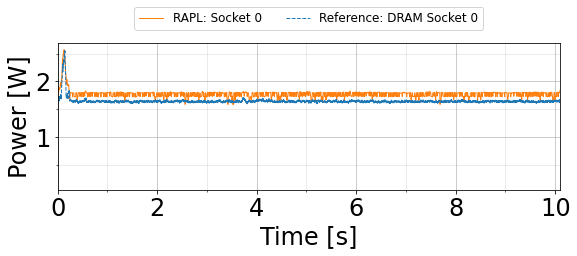

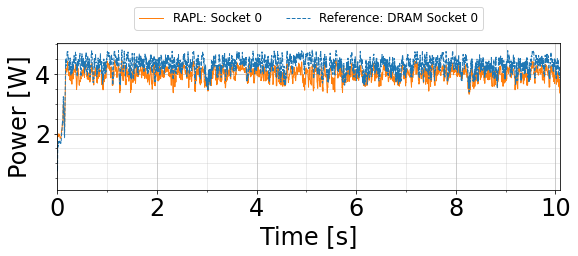

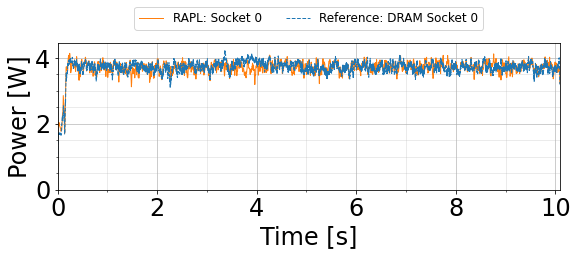

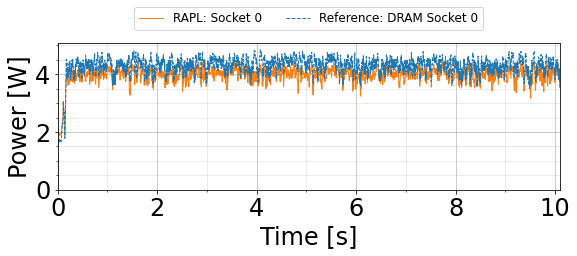

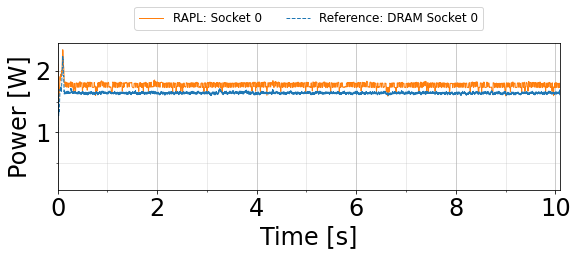

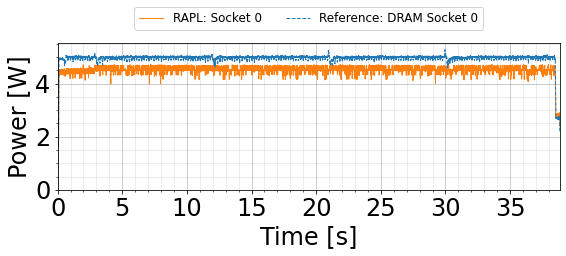

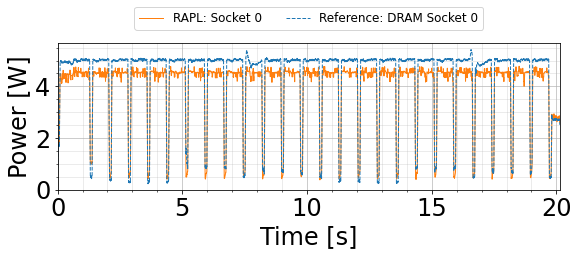

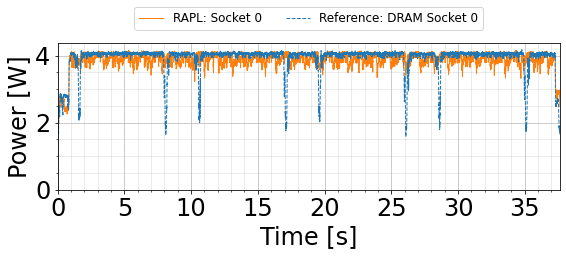

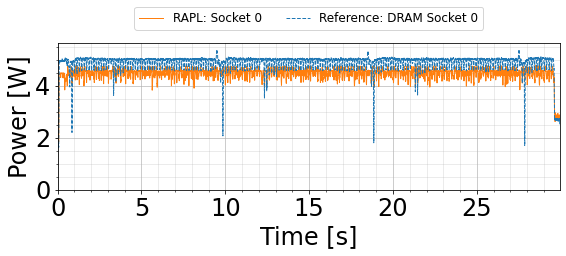

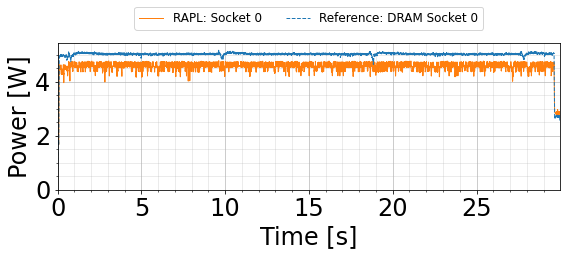

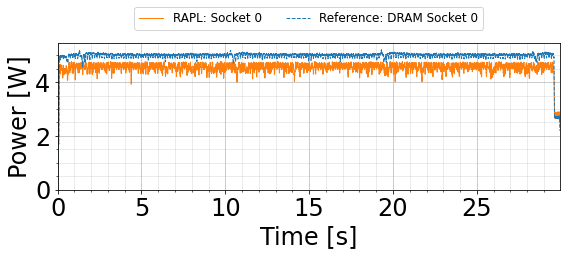

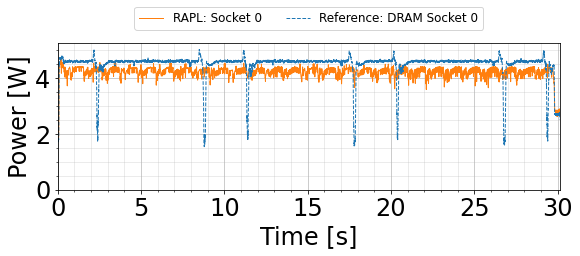

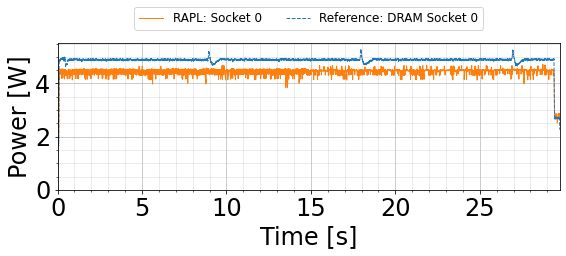

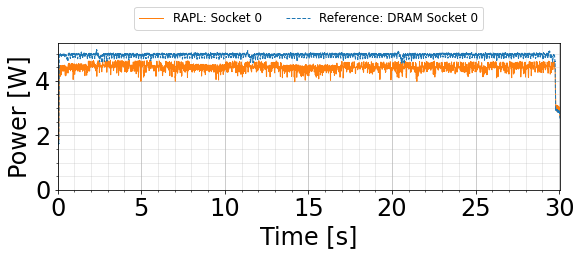

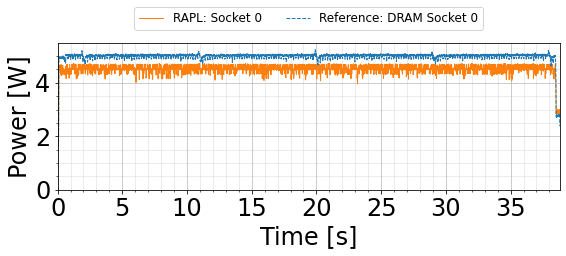

In [29]:
m.rcParams.update({"font.size": 24, "legend.fontsize": 20, 'pdf.fonttype': 42, 'ps.fonttype': 42})
visualize_phase_plots("broadwell/", ["ddr4-2x16gb-2400-socket0/2023-09-05"])

792d4015 icelake\ddr4-32gb-3200-socket0\2023-09-05\addpd 38.06927282175553 93.7075 10.2360s 246.15%
99276c1e icelake\ddr4-32gb-3200-socket0\2023-09-05\busywait 37.4412368606446 92.9752 10.0730s 248.32%
8c540771 icelake\ddr4-32gb-3200-socket0\2023-09-05\compute 54.61783836619362 108.0521 10.0770s 197.83%
182ca6f7 icelake\ddr4-32gb-3200-socket0\2023-09-05\idle 37.445339898293454 93.99719999999999 10.0700s 251.03%
84f9d9a0 icelake\ddr4-32gb-3200-socket0\2023-09-05\matmul 37.425582060210985 92.6857 10.0710s 247.65%
7ac726e6 icelake\ddr4-32gb-3200-socket0\2023-09-05\memorycopy 59.40739007400623 111.9476 10.0710s 188.44%
42830eab icelake\ddr4-32gb-3200-socket0\2023-09-05\memoryread 50.912016545277325 104.6406 10.0720s 205.53%
adf243ea icelake\ddr4-32gb-3200-socket0\2023-09-05\memorywrite 77.79683250326597 126.11340000000001 10.0750s 162.11%
e0455c02 icelake\ddr4-32gb-3200-socket0\2023-09-05\mulpd 37.48012495098246 91.91829999999999 10.0690s 245.25%
ab15b038 icelake\ddr4-32gb-3200-socket0\202

C:\Users\lukas\AppData\Local\Temp\ipykernel_17000\2419188827.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9, 3))


5087b0a9 icelake\dram\2023-08-28\compute 67.75486194432901 92.888 10.0800s 137.09%
df22789f icelake\dram\2023-08-28\idle 51.46816060811818 77.00110000000001 10.0740s 149.61%
9dc69334 icelake\dram\2023-08-28\matmul 52.005485418759406 77.6146 10.0740s 149.24%
cd7b023e icelake\dram\2023-08-28\memorycopy 70.41283682771913 95.3583 10.0740s 135.43%
cc261e89 icelake\dram\2023-08-28\memoryread 59.47283780229853 84.7405 10.0810s 142.49%
6051014f icelake\dram\2023-08-28\memorywrite 89.2655696877943 111.20439999999999 10.0750s 124.58%
f2a7dcf4 icelake\dram\2023-08-28\mulpd 51.9016438659426 76.74969999999999 10.0800s 147.88%
1526aace icelake\dram\2023-08-28\stream_add 214.01289142099114 265.0874 24.6040s 123.87%
9f876409 icelake\dram\2023-08-28\stream_combined 106.30237640402237 133.4804 13.3430s 125.57%
d6b1d889 icelake\dram\2023-08-28\stream_copy_1 216.47060385424948 281.1213 29.5460s 129.87%
ba1bdf2c icelake\dram\2023-08-28\stream_copy_16 169.17247848370118 211.2964 20.2120s 124.90%
47a11d93 ic

f0128310 icelake\ddr4-2x32gb-3200\2023-09-05\stream_copy_4 130.82089575136854 146.00189999999998 13.6040s 111.60%
d41646b9 icelake\ddr4-2x32gb-3200\2023-09-05\stream_copy_8 125.71446207808543 138.71280000000002 12.3590s 110.34%
9d94d6ca icelake\ddr4-2x32gb-3200\2023-09-05\stream_scale 101.47576122018397 110.221 9.1850s 108.62%
f00ceb7d icelake\ddr4-2x32gb-3200\2023-09-05\stream_triad 146.80196197341743 158.6274 12.8260s 108.06%


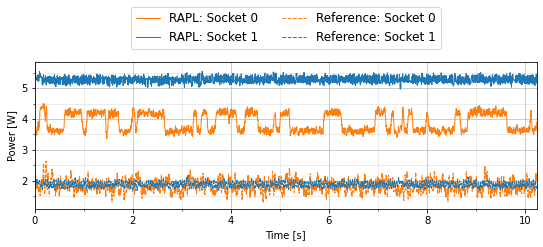

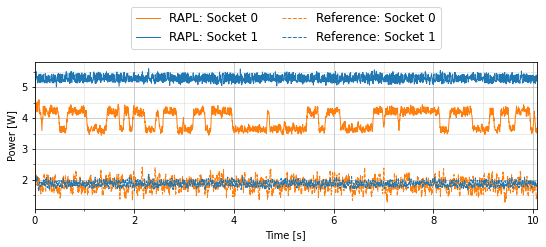

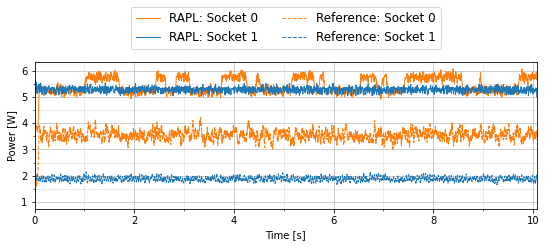

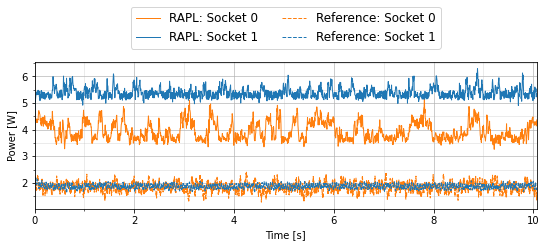

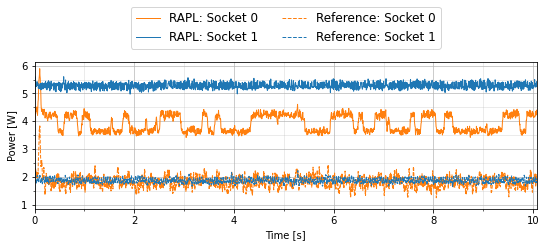

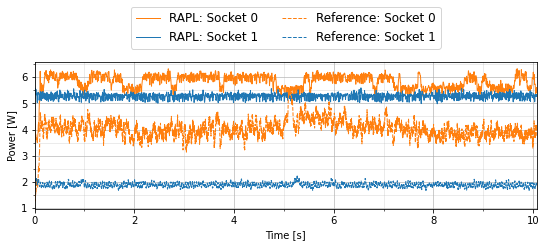

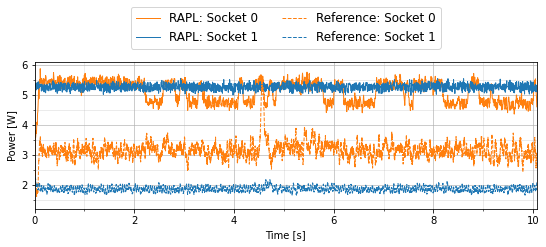

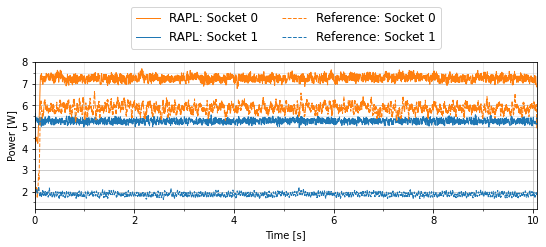

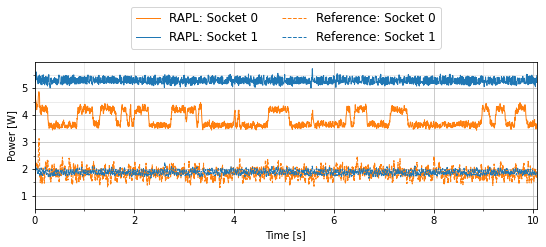

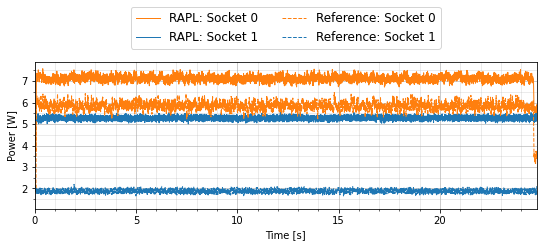

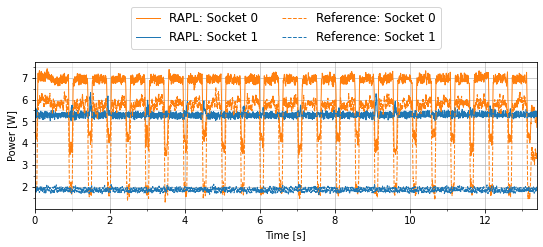

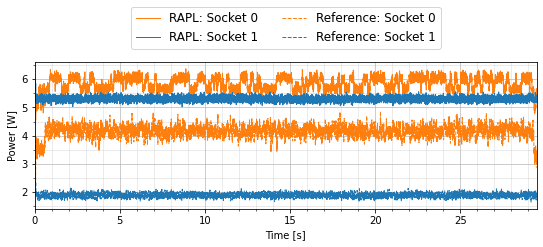

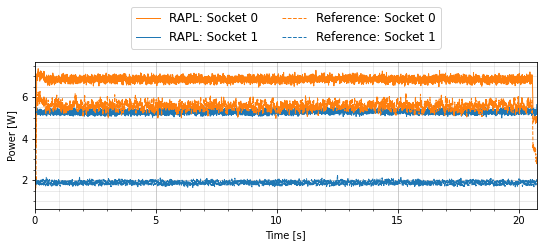

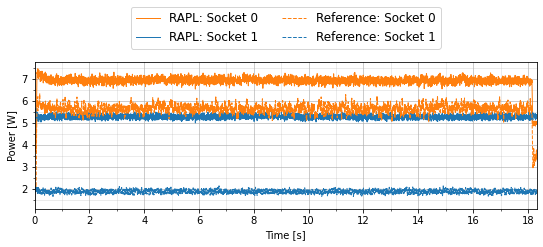

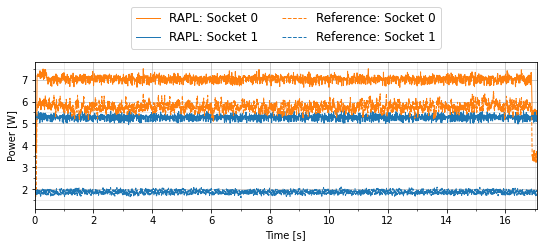

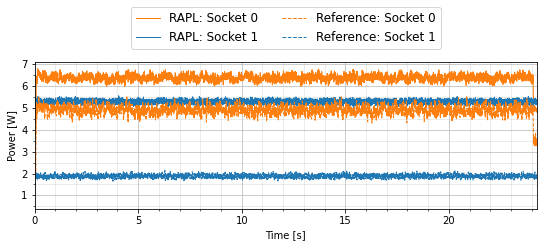

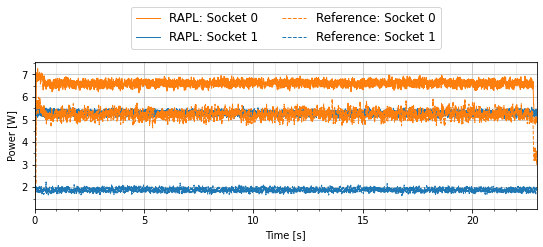

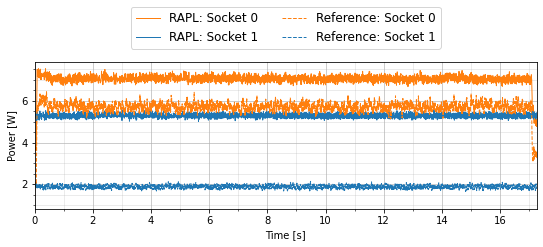

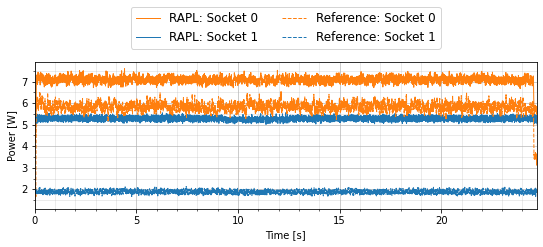

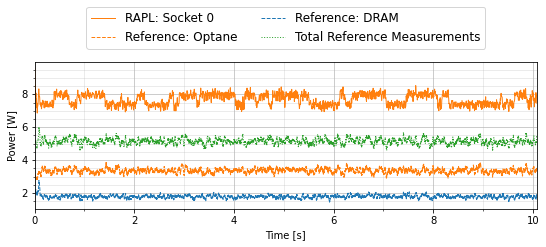

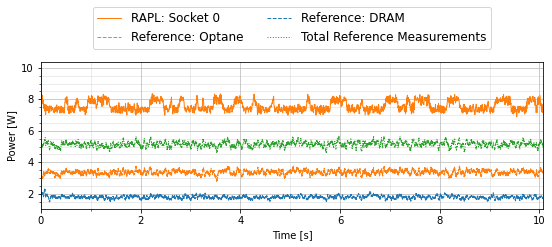

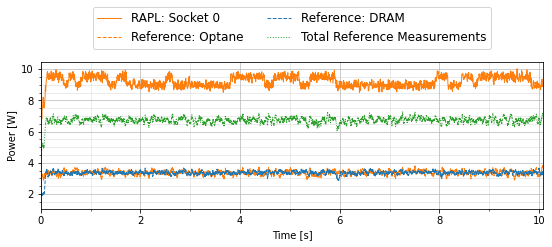

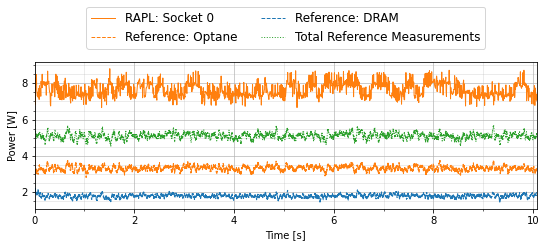

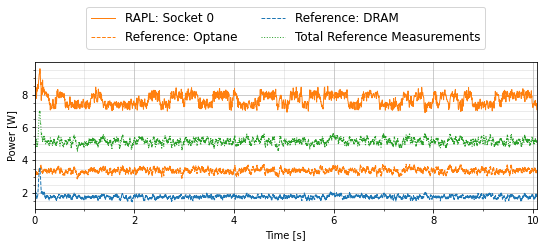

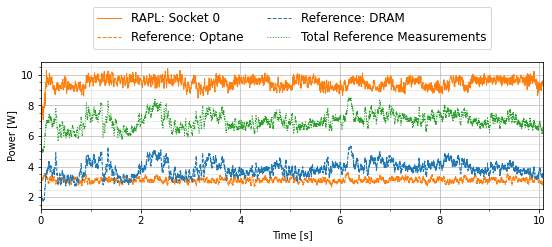

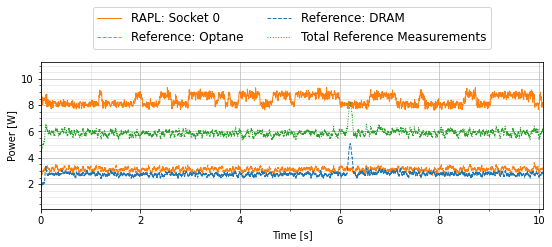

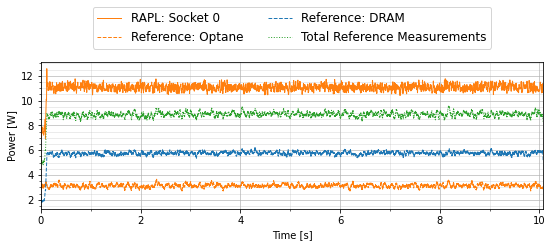

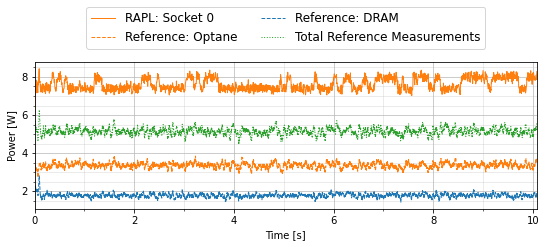

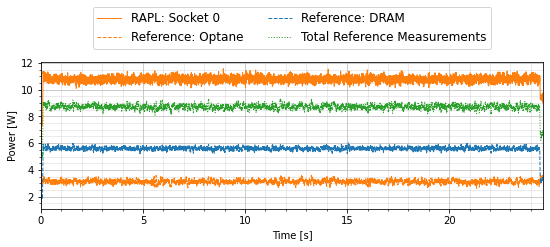

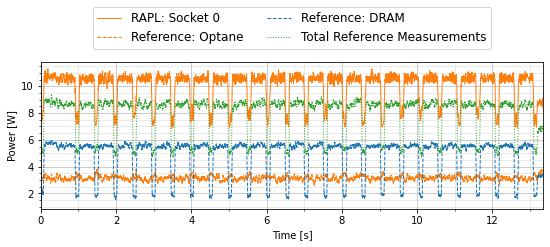

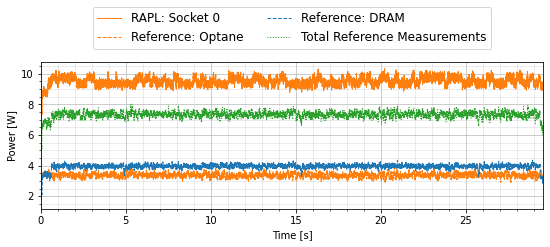

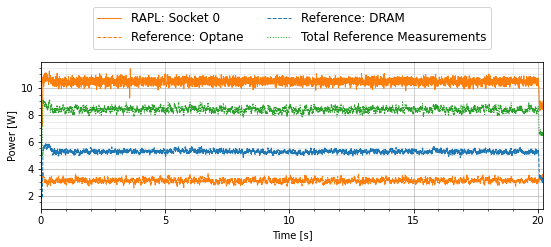

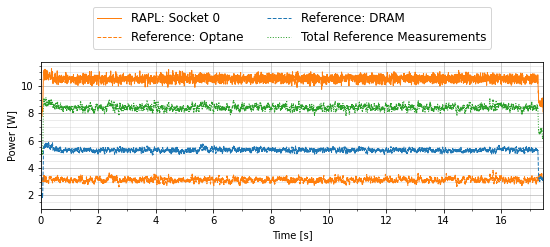

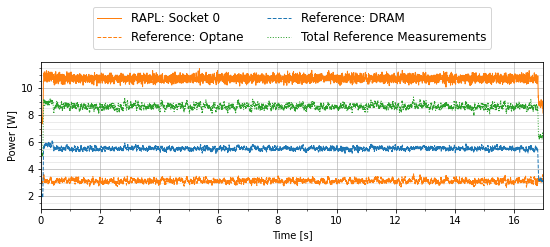

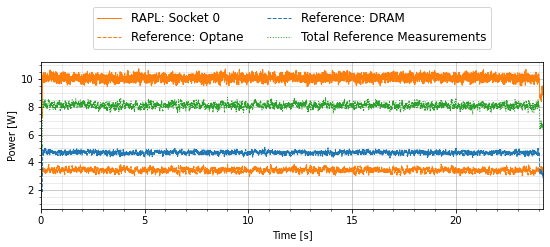

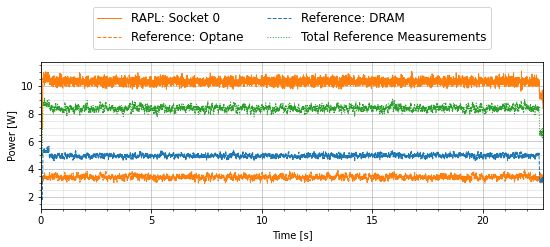

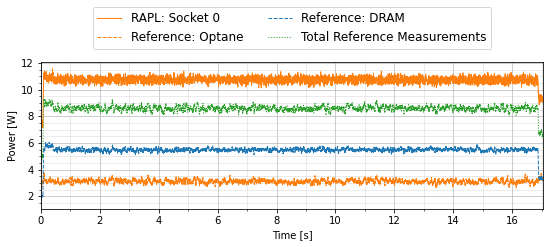

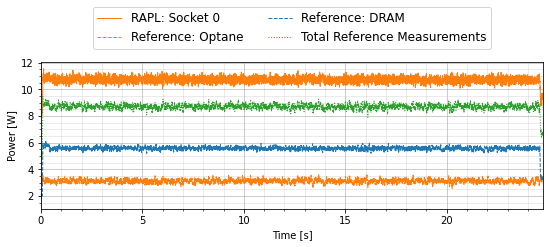

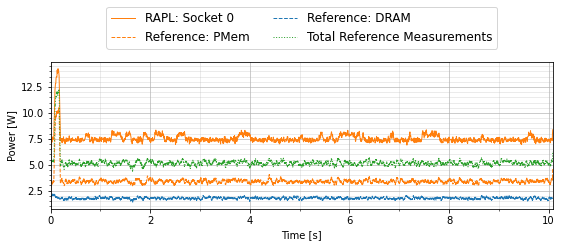

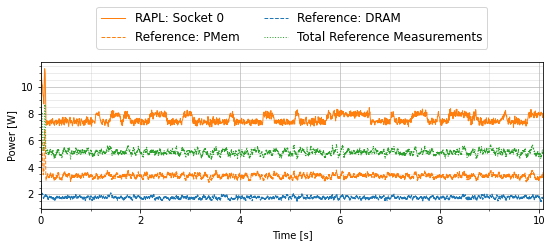

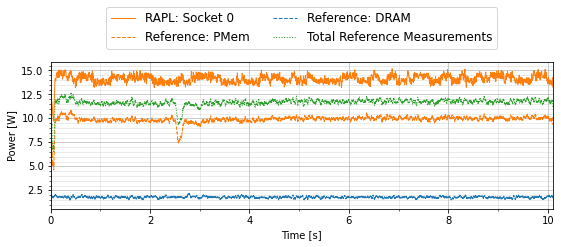

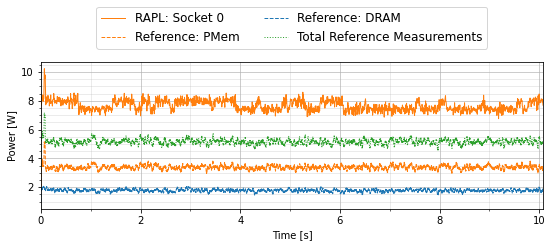

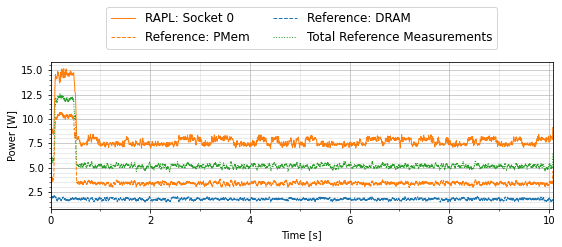

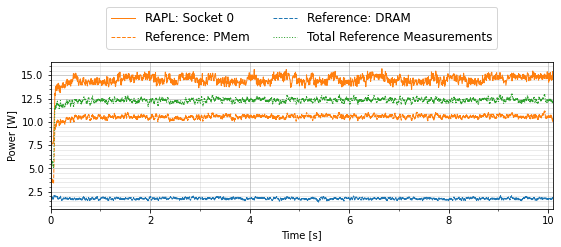

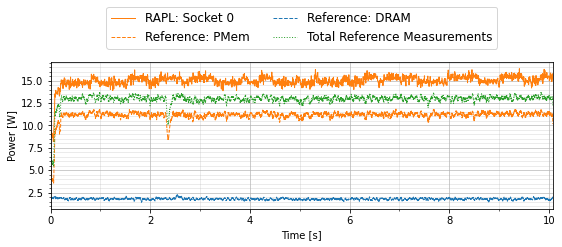

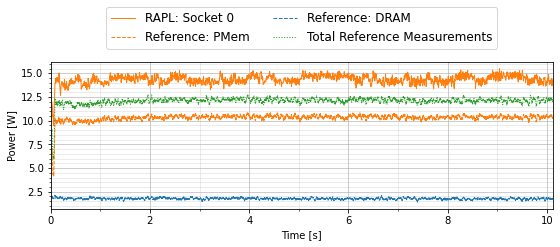

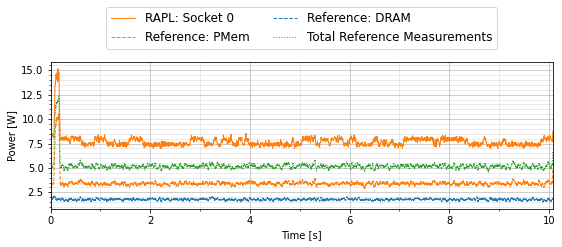

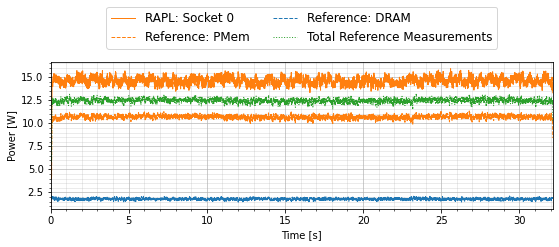

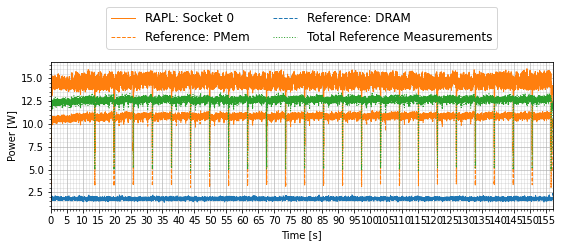

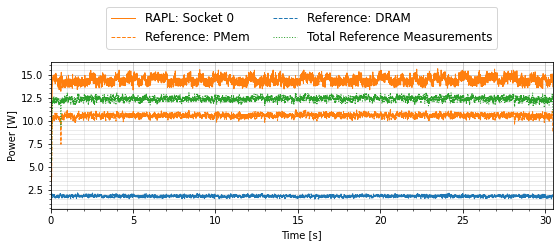

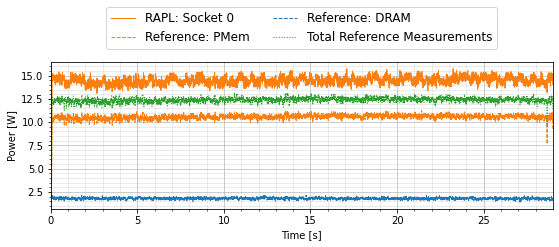

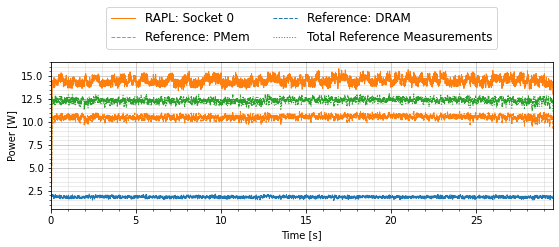

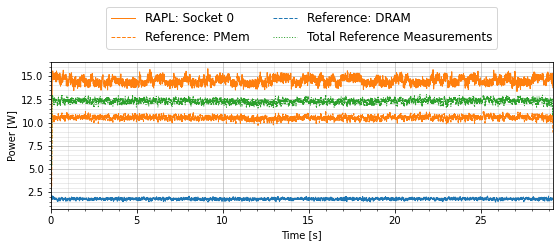

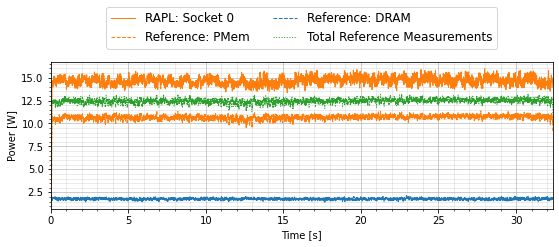

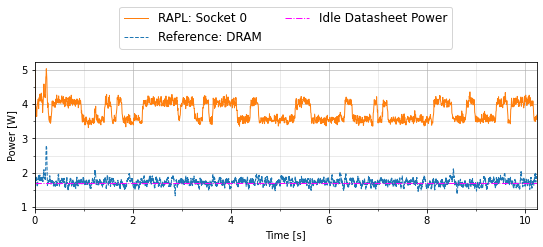

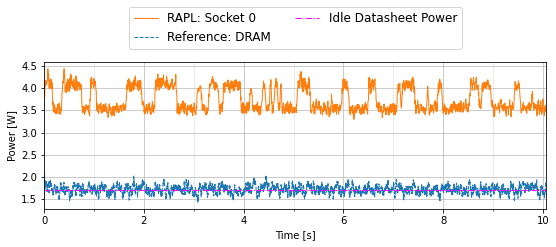

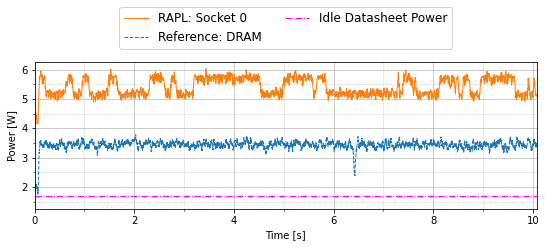

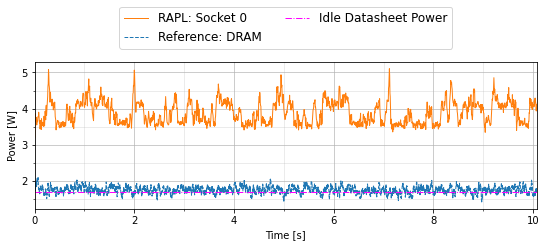

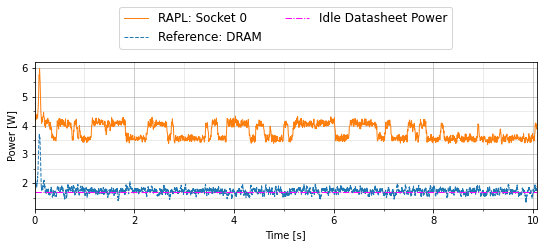

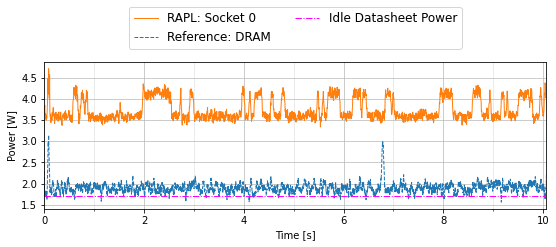

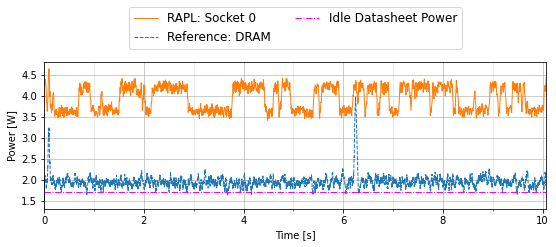

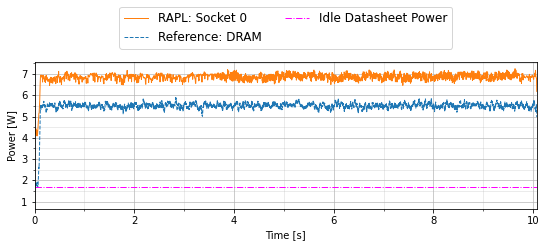

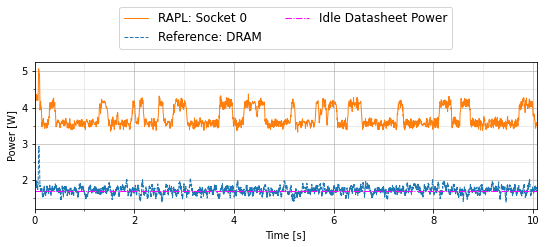

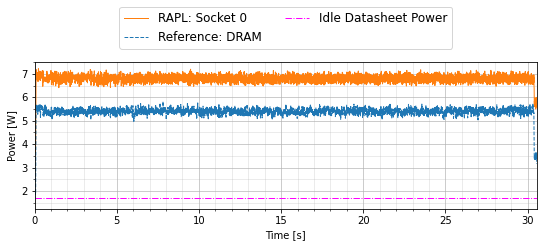

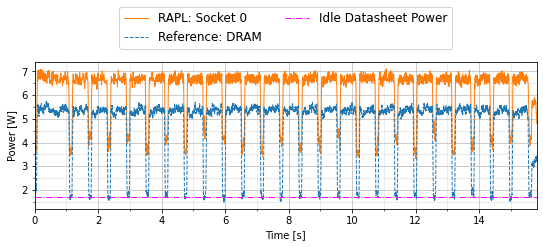

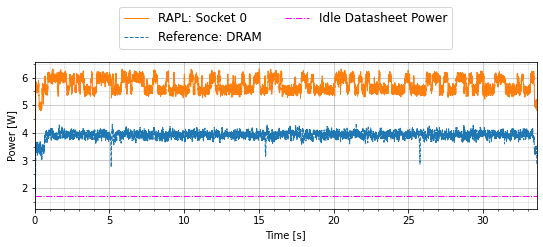

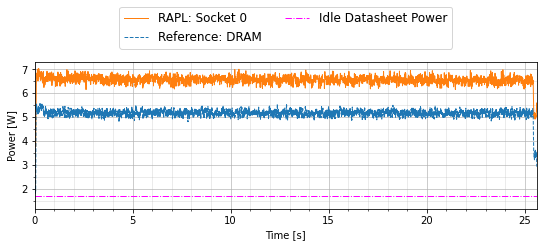

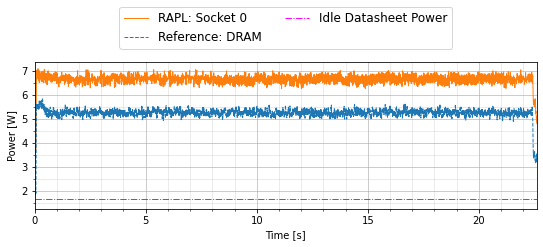

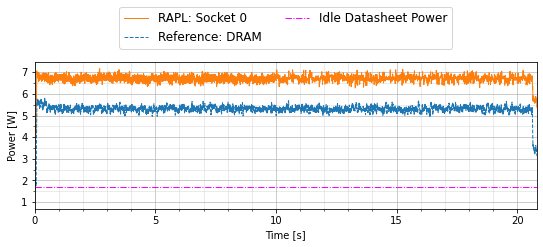

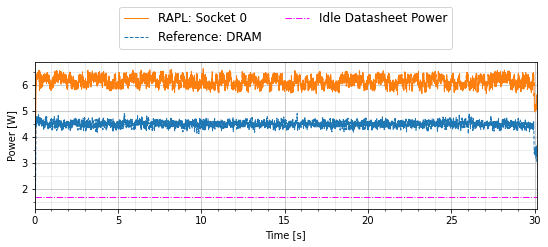

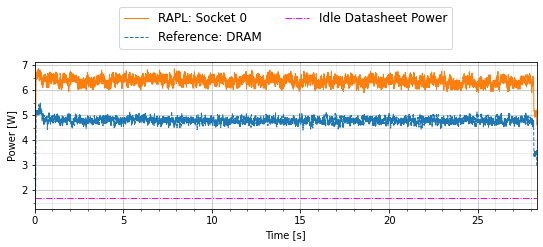

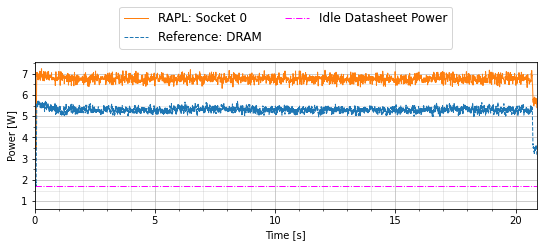

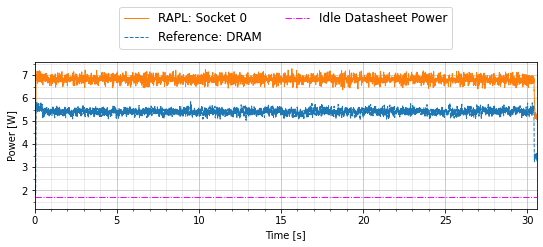

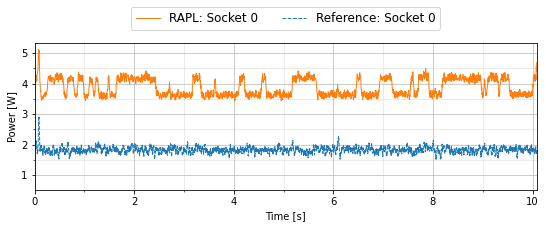

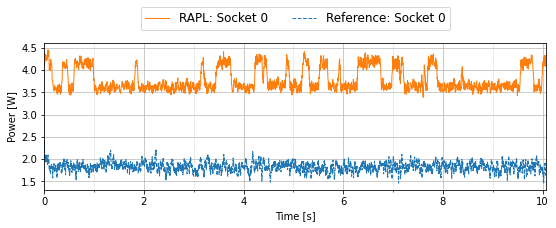

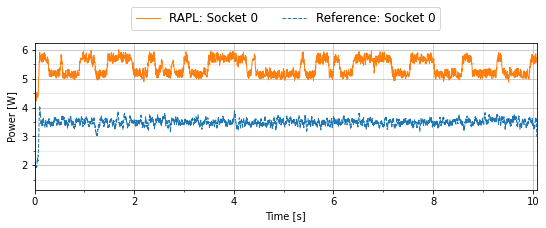

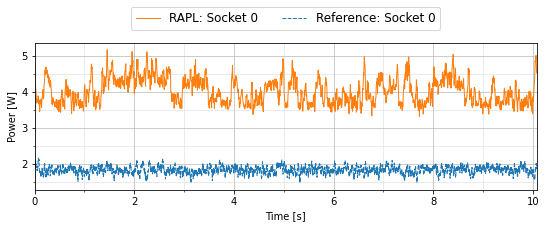

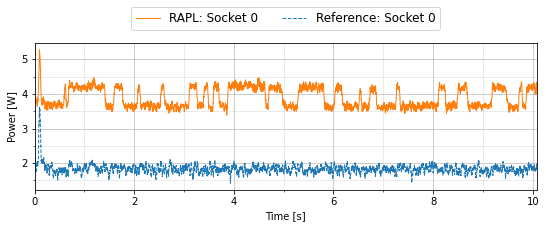

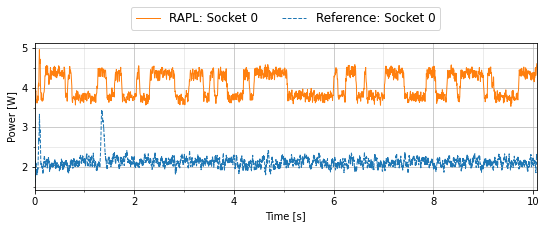

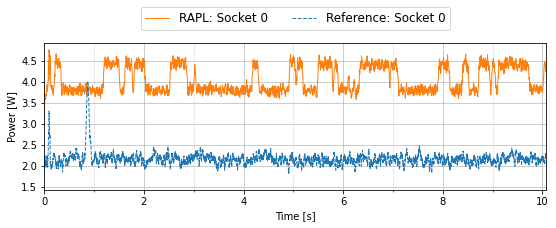

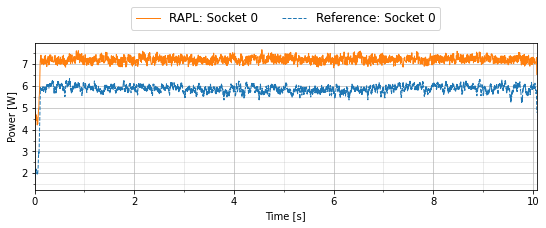

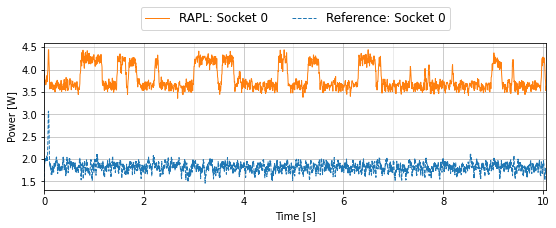

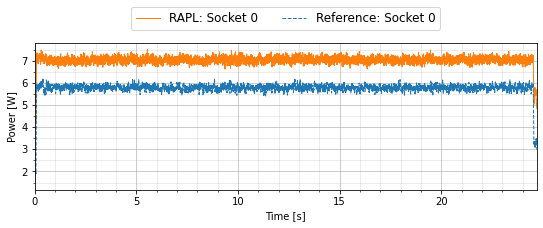

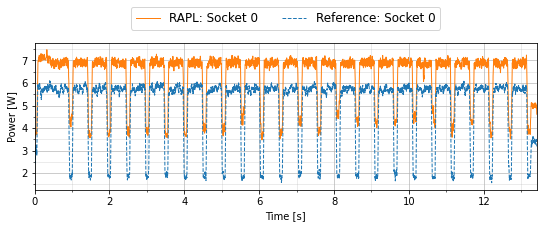

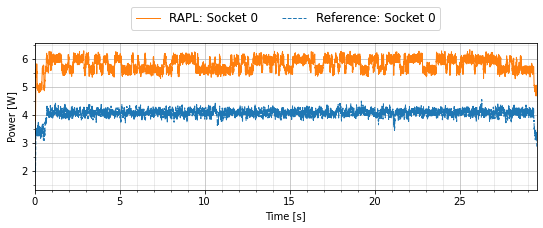

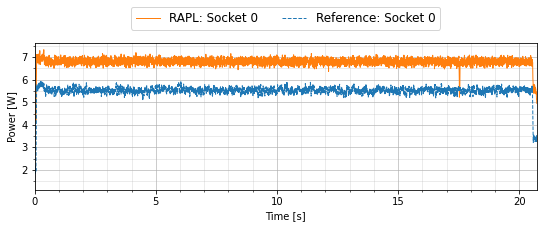

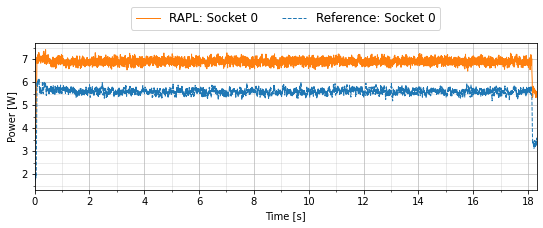

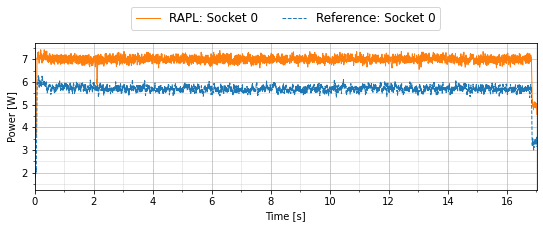

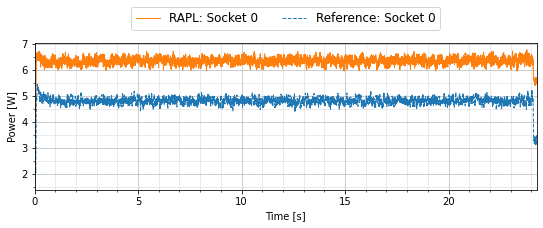

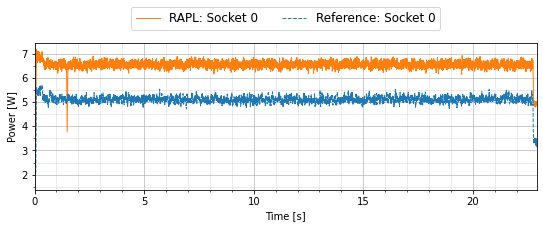

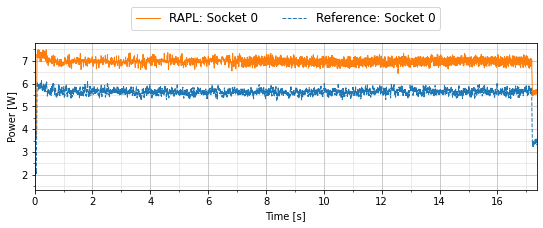

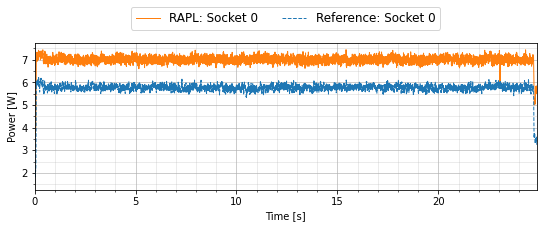

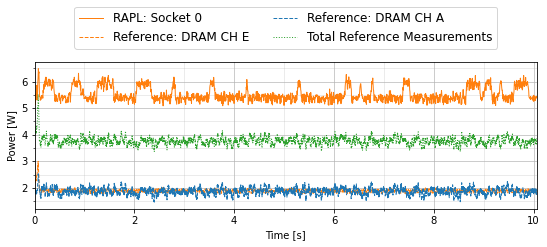

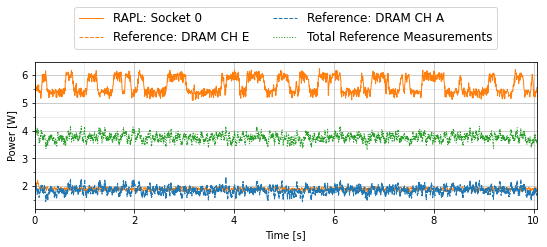

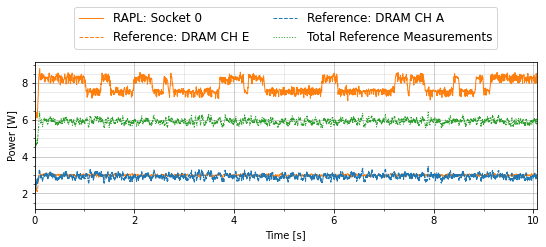

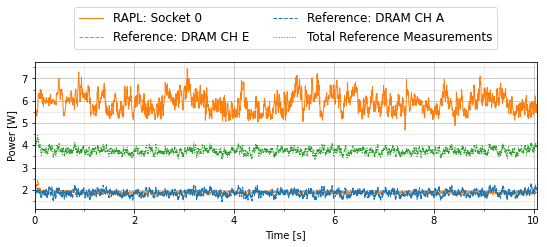

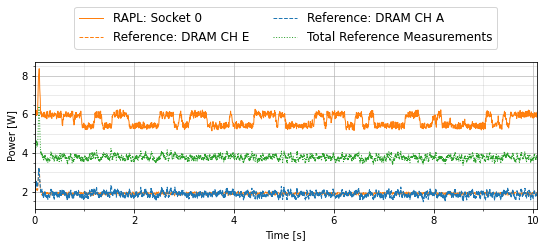

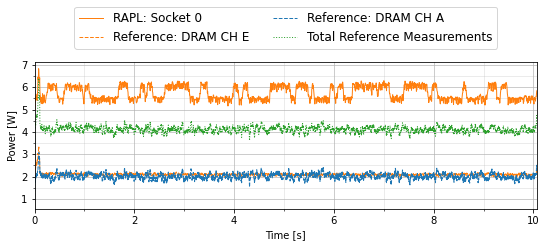

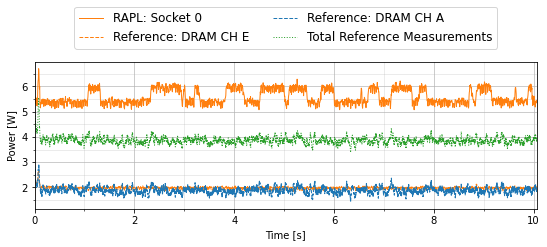

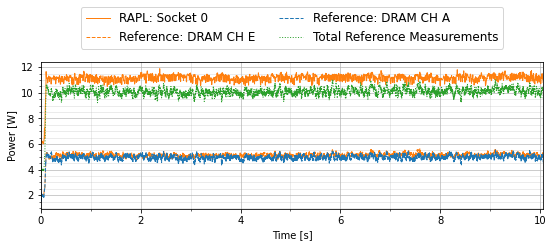

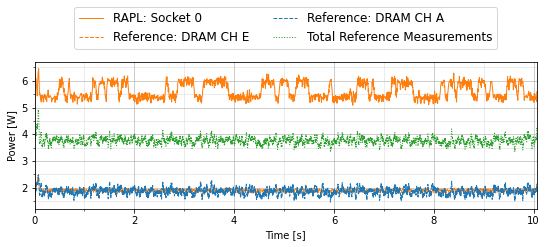

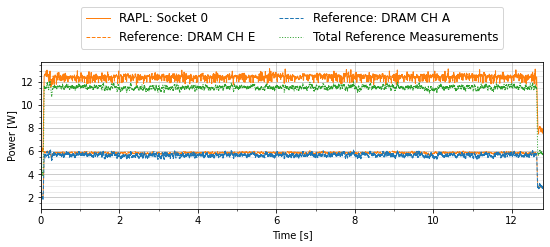

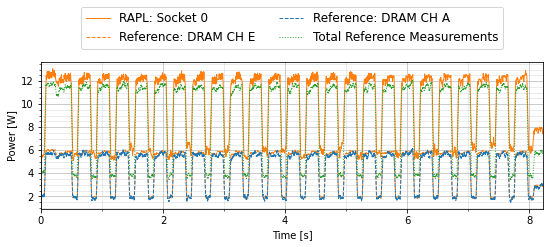

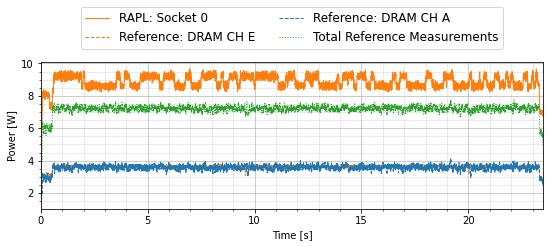

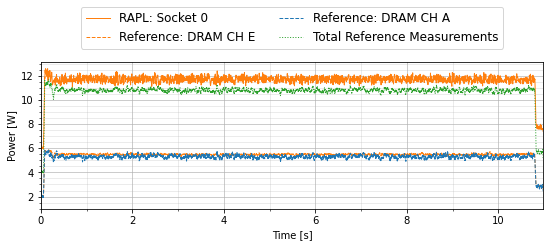

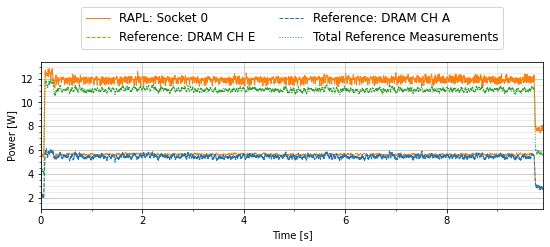

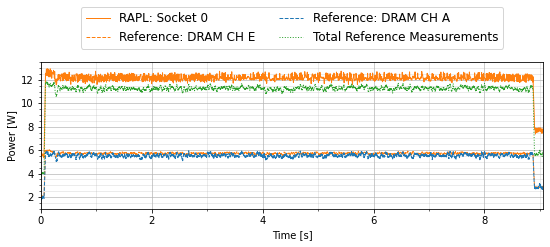

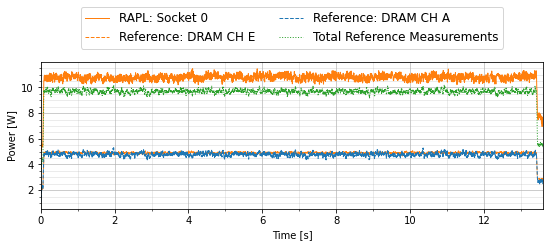

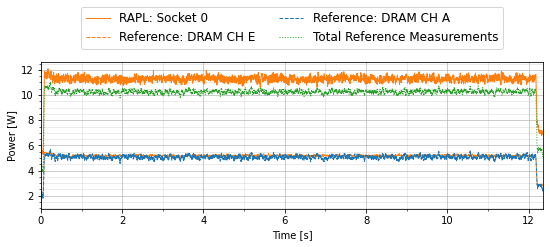

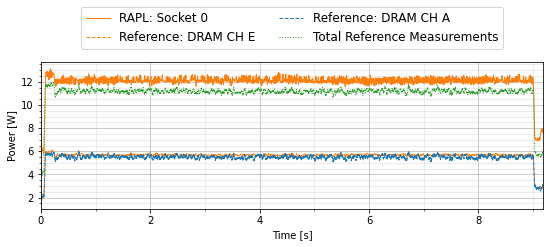

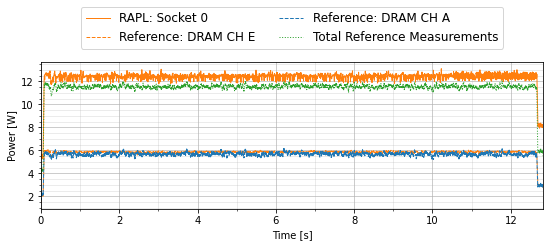

In [13]:
m.rcParams.update({"font.size": 18, "legend.fontsize": 16, 'pdf.fonttype': 42, 'ps.fonttype': 42})
visualize_phase_plots("icelake/", ["ddr4-32gb-3200-socket0/2023-09-05", "dram/2023-08-28", "optane/2023-08-28", "ddr4-16gb-2400/2023-08-28", "ddr4-32gb-3200/2023-08-28", "ddr4-2x32gb-3200/2023-09-05"])

In [28]:
energy_errors

{'128b SSE Add (1 Thread)': {'icelake': {'icelake\\ddr4-32gb-3200-socket0\\2023-09-05\\addpd': 2.4614996046483126,
   'icelake\\dram\\2023-08-28\\addpd': 1.4936443793860223,
   'icelake\\optane\\2023-08-28\\addpd': 1.449473437143546,
   'icelake\\ddr4-16gb-2400\\2023-08-28\\addpd': 2.192219950331808,
   'icelake\\ddr4-32gb-3200\\2023-08-28\\addpd': 2.1257693211489066,
   'icelake\\ddr4-2x32gb-3200\\2023-09-05\\addpd': 1.4645504534348945},
  'broadwell': {'broadwell\\ddr4-2x16gb-2400-socket0\\2023-09-05\\addpd': 1.0788737945474063}},
 'Busy Waiting': {'icelake': {'icelake\\ddr4-32gb-3200-socket0\\2023-09-05\\busywait': 2.483229930305227,
   'icelake\\dram\\2023-08-28\\busywait': 1.4706510024521915,
   'icelake\\optane\\2023-08-28\\busywait': 1.4760506516035607,
   'icelake\\ddr4-16gb-2400\\2023-08-28\\busywait': 2.1767871886477423,
   'icelake\\ddr4-32gb-3200\\2023-08-28\\busywait': 2.0738017040398766,
   'icelake\\ddr4-2x32gb-3200\\2023-09-05\\busywait': 1.4996727020969185},
  'broadwe

In [35]:

for workload, item in energy_errors.items():
    line = "Workload"
    for system, item2 in item.items():
        for memory, val in item2.items():
            if "ddr4-32gb-3200-socket0" in memory:
                continue
            line = line + " & " + memory.split("\\")[1]
    print(line)
    break
for workload, item in energy_errors.items():
    line = workload
    for system, item2 in item.items():
        for memory, val in item2.items():
            if "ddr4-32gb-3200-socket0" in memory:
                continue
            line = line + f" & {100*(val-1.0):.1f}\%"
    print(line, "\\\\")

Workload & dram & optane & ddr4-16gb-2400 & ddr4-32gb-3200 & ddr4-2x32gb-3200 & ddr4-2x16gb-2400-socket0
128b SSE Add (1 Thread) & 49.4\% & 44.9\% & 119.2\% & 112.6\% & 46.5\% & 7.9\% \\
Busy Waiting & 47.1\% & 47.6\% & 117.7\% & 107.4\% & 50.0\% & 7.9\% \\
Dot Product (1 Thread) & 37.1\% & 20.8\% & 58.0\% & 54.8\% & 32.8\% & 4.0\% \\
Sleep & 49.6\% & 48.4\% & 121.6\% & 118.1\% & 57.7\% & 35.3\% \\
DGEMM (1 Thread) & 49.2\% & 45.8\% & 119.0\% & 112.3\% & 50.3\% & 8.0\% \\
Memory Copy (32 Threads) & 35.4\% & 97.6\% & 91.7\% & 39.3\% & -7.0\% \\
Memory Read (32 Threads) & 42.5\% & 101.6\% & 87.1\% & 44.8\% & -0.1\% \\
Memory Write (32 Threads) & 24.6\% & 24.9\% & 23.0\% & 11.1\% & -6.9\% \\
128b SSE Mult. (1 Thread) & 47.9\% & 47.3\% & 116.4\% & 108.8\% & 49.3\% & 8.2\% \\
STREAM Add (32 Threads) & 23.9\% & 26.4\% & 21.9\% & 8.2\% & -9.6\% \\
STREAM (32 Threads) & 25.6\% & 31.2\% & 27.3\% & 13.5\% & -9.5\% \\
STREAM Copy (1 Thread) & 29.9\% & 16.7\% & 46.2\% & 43.1\% & 23.4\% & -2.3\% \\

0 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\addpd\6def37cd_perf.txt
1 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\busywait\7cd7e030_perf.txt
2 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\compute\8dc6d845_perf.txt
3 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\idle\759d8d02_perf.txt
4 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\matmul\d4e6e0b3_perf.txt
5 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memorycopy\9c27e139_perf.txt
6 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memoryread\0f4e5b82_perf.txt
7 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\memorywrite\0d46d2a3_perf.txt
8 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\mulpd\68f56b35_perf.txt
9 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\stream_add\bf1bfecb_perf.txt
10 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\stream_combined\c789ecc2_perf.txt
11 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\stream_copy_1\bd66e937_perf.txt
12 broadwell\ddr4-2x16gb-2400-socket0\2023-09-05\stream_copy_16\5ac87f71_perf.txt
13 broad

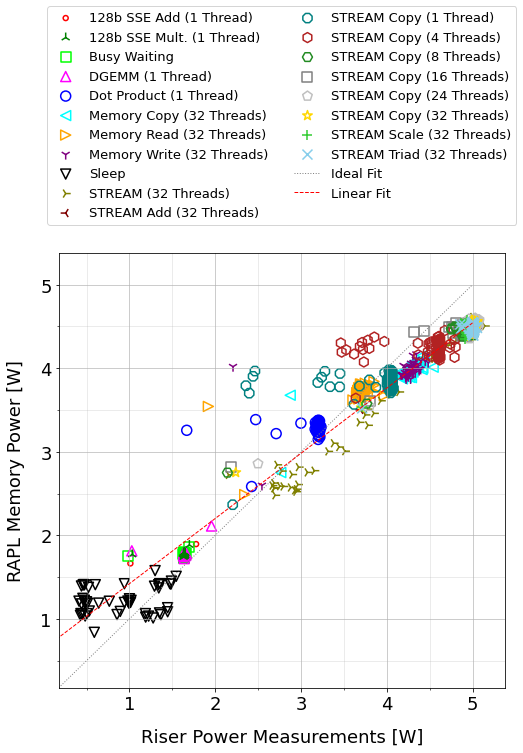

In [15]:
m.rcParams.update({"font.size": 18, "legend.fontsize": 20, 'pdf.fonttype': 42, 'ps.fonttype': 42})
visualize_scatter_plot("broadwell/", ["ddr4-2x16gb-2400-socket0/2023-09-05"], extra_legend=False, legend_cols=2)

0 icelake\ddr4-32gb-3200-socket0\2023-09-05\addpd\792d4015_perf.txt
1 icelake\ddr4-32gb-3200-socket0\2023-09-05\busywait\99276c1e_perf.txt
2 icelake\ddr4-32gb-3200-socket0\2023-09-05\compute\8c540771_perf.txt
3 icelake\ddr4-32gb-3200-socket0\2023-09-05\idle\182ca6f7_perf.txt
4 icelake\ddr4-32gb-3200-socket0\2023-09-05\matmul\84f9d9a0_perf.txt
5 icelake\ddr4-32gb-3200-socket0\2023-09-05\memorycopy\7ac726e6_perf.txt
6 icelake\ddr4-32gb-3200-socket0\2023-09-05\memoryread\42830eab_perf.txt
7 icelake\ddr4-32gb-3200-socket0\2023-09-05\memorywrite\adf243ea_perf.txt
8 icelake\ddr4-32gb-3200-socket0\2023-09-05\mulpd\e0455c02_perf.txt
9 icelake\ddr4-32gb-3200-socket0\2023-09-05\stream_add\ab15b038_perf.txt
10 icelake\ddr4-32gb-3200-socket0\2023-09-05\stream_combined\91ab314e_perf.txt
11 icelake\ddr4-32gb-3200-socket0\2023-09-05\stream_copy_1\2d97f82d_perf.txt
12 icelake\ddr4-32gb-3200-socket0\2023-09-05\stream_copy_16\071a7362_perf.txt
13 icelake\ddr4-32gb-3200-socket0\2023-09-05\stream_copy_24\

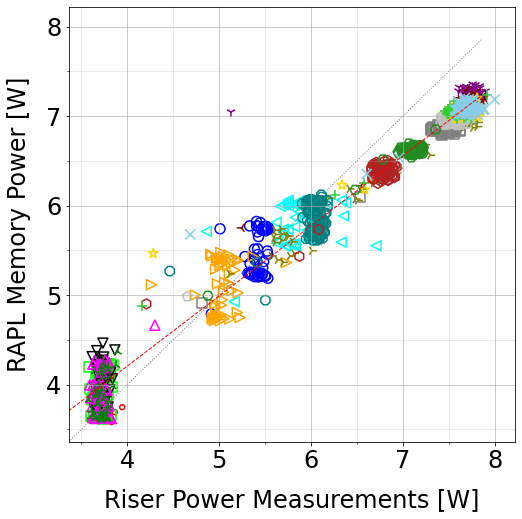

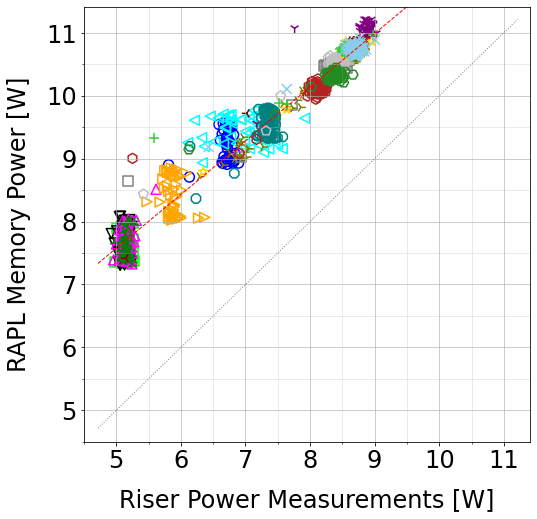

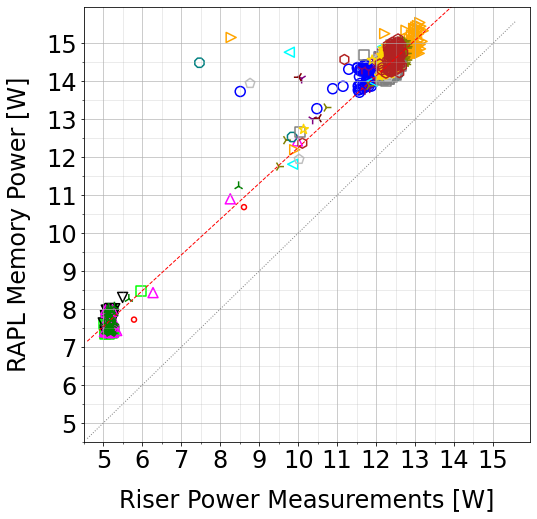

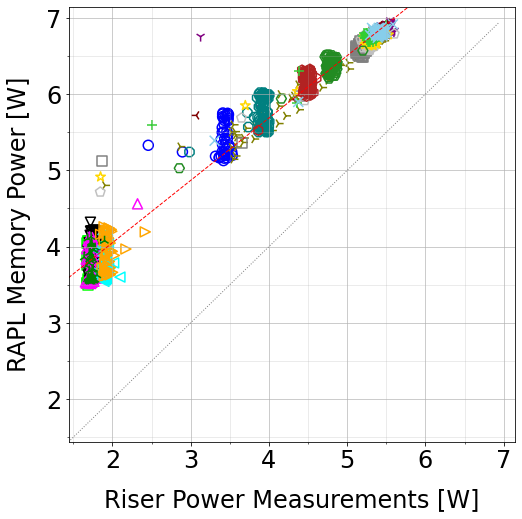

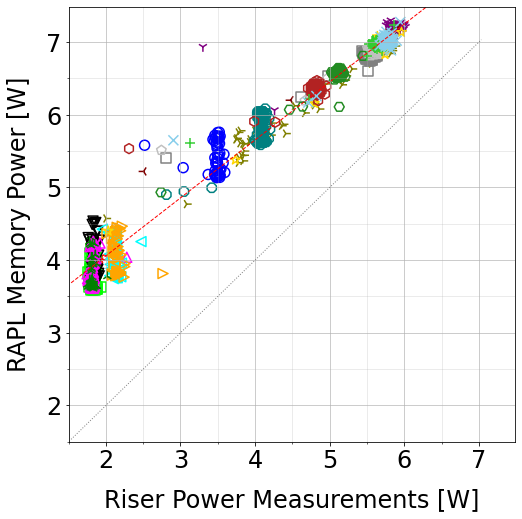

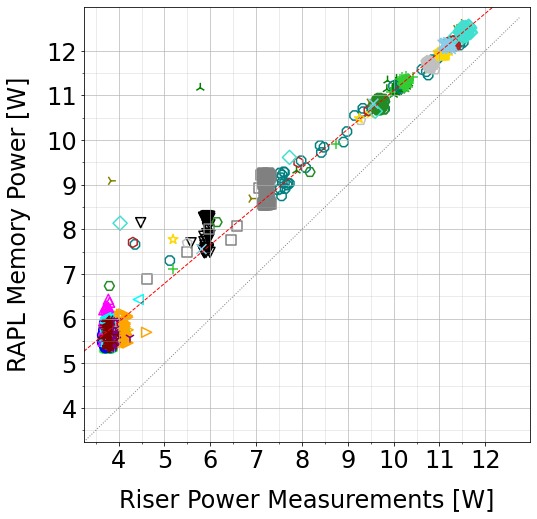

In [72]:
m.rcParams.update({"font.size": 24, "legend.fontsize": 20, 'pdf.fonttype': 42, 'ps.fonttype': 42})
visualize_scatter_plot("icelake/", ["ddr4-32gb-3200-socket0/2023-09-05", "dram/2023-08-28", "optane/2023-08-28", "ddr4-16gb-2400/2023-08-28", "ddr4-32gb-3200/2023-08-28", "ddr4-2x32gb-3200/2023-09-05"], extra_legend=True)

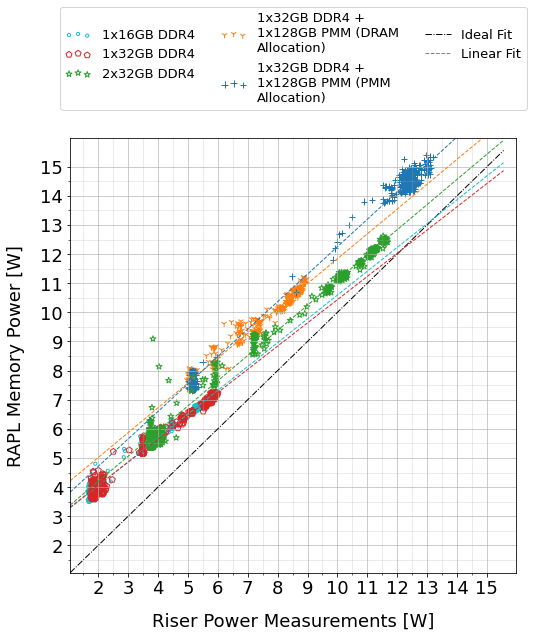

In [19]:
m.rcParams.update({"font.size": 18, "legend.fontsize": 20, 'pdf.fonttype': 42, 'ps.fonttype': 42})
visualize_combined_scatter_plot("icelake/", ["dram/2023-08-28", "optane/2023-08-28", "ddr4-16gb-2400/2023-08-28", "ddr4-32gb-3200/2023-08-28", "ddr4-2x32gb-3200/2023-09-05"])